In [1]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Statistics
using JLD
using Distributions
using FFTW

In [47]:
# output the plugin Iterate
function PLUGIN_denoise(G, W, y, z, stepsize)
    d = W'* (G(z) - y )
    return z - stepsize * d
end

# output the plugin Iterate
function PLUGIN_denoise_regularized(G, W, y, z, stepsize, λ)
    d = W'* (G(z) - y )  
    return z - stepsize * d - 2 * λ * z 
end

PLUGIN_denoise_regularized (generic function with 1 method)

In [3]:
function normalized_weight_product(G)
    (_, z_dim) = size(Flux.params(G[1])[1]);
    W = I(z_dim)
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /(s[1]^2)
    end
    return W
end  

function create_network(net_param)
    n_0 = net_param[1]
    n_1 = net_param[2]
    L = Chain(Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))

    for i in 2:length(net_param)-1
        n_0 = net_param[i]
        n_1 = net_param[i+1]
        L = Chain(L, Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))
    end
    return L
end


function relative_error(x̂,x̃)
    return norm(x̃ - x̂, 2)/norm(x̂, 2)
end


relative_error (generic function with 1 method)

In [20]:
function SNR(G)
    depth = length(Flux.params(G))/2

    (_, z_dim) = size(Flux.params(G)[1]);
    (x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
    W = normalized_weight_product(G)

    max_iter = 1000
    stepsize = 1

    λ = .002

    noise_level_list = 0:.1:1
    trials = 4

    recov_error_matrix_PLUGIn = zeros(length(noise_level_list))
    recon_error_matrix_PLUGIn = zeros(length(noise_level_list))

    recov_error_matrix_PLUGIn_reg = zeros(length(noise_level_list))
    recon_error_matrix_PLUGIn_reg = zeros(length(noise_level_list))

    recov_error_matrix_GD = zeros(length(noise_level_list))
    recon_error_matrix_GD = zeros(length(noise_level_list))

    for trial in 1:trials

        recov_error_PLUGIn = []
        recon_error_PLUGIn = []

        recov_error_PLUGIn_reg = []
        recon_error_PLUGIn_reg = []

        recov_error_GD = []
        recon_error_GD = []

        z = randn(z_dim)
        
        for noise_level in noise_level_list
            y = G(z) + noise_level * randn(x_dim)
            descent(z) = gradient(z->norm(G(z) - y,2)^2, z)[1]        

            z_est_PLUGIn = randn(z_dim)
            z_est_PLUGIn_reg = randn(z_dim)
            z_est_GD = randn(z_dim)
            iter = 1
            for iter in 1:max_iter
                z_est_PLUGIn = PLUGIN_denoise(G, W, y, z_est_PLUGIn, stepsize)
                z_est_PLUGIn_reg = PLUGIN_denoise_regularized(G, W, y, z_est_PLUGIn_reg, stepsize, λ)
                d = descent(z_est_GD); z_est_GD -= stepsize *d
            end

            push!(recov_error_PLUGIn, norm(z - z_est_PLUGIn)) #relative_error(z, z_est_PLUGIn))
            push!(recon_error_PLUGIn,  norm(G(z) - G(z_est_PLUGIn))) #relative_error(G(z), G(z_est_PLUGIn)) )

            push!(recov_error_PLUGIn_reg,  norm(z - z_est_PLUGIn_reg)) #relative_error(z, z_est_PLUGIn_reg))
            push!(recon_error_PLUGIn_reg,  norm(G(z) - G(z_est_PLUGIn_reg))) #relative_error(G(z), G(z_est_PLUGIn_reg)) )

            push!(recov_error_GD,  norm(z - z_est_GD)) #relative_error(z, z_est_GD))
            push!(recon_error_GD,  norm(G(z) - G(z_est_GD))) #relative_error(G(z), G(z_est_GD)) )  

        end

        recov_error_matrix_PLUGIn = hcat(recov_error_matrix_PLUGIn, recov_error_PLUGIn)
        recon_error_matrix_PLUGIn =  hcat(recon_error_matrix_PLUGIn, recon_error_PLUGIn)

        recov_error_matrix_PLUGIn_reg = hcat(recov_error_matrix_PLUGIn_reg, recov_error_PLUGIn_reg)
        recon_error_matrix_PLUGIn_reg =  hcat(recon_error_matrix_PLUGIn_reg, recon_error_PLUGIn_reg)

        recov_error_matrix_GD = hcat(recov_error_matrix_GD, recov_error_GD)
        recon_error_matrix_GD = hcat(recon_error_matrix_GD, recon_error_GD)

        println("Done with trial $trial")

    end

    average_recov = mean(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
    plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.5, c = 0, label = false)
    plot!(noise_level_list, average_recov, label = "PLUGIn", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:black)
    
    average_recov = mean(recov_error_matrix_GD[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_GD[:, 2:end], dims=2)
    plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 2, label = false)
    plot!(noise_level_list, average_recov, label = "Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:red)
    

    average_recov = mean(recov_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
    plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.75, c = 9, label = false)
    p1 = plot!(noise_level_list, average_recov, label = "PLUGIn normalized", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:yellow)
    
    
    average_recon = mean(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
    plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.5, c = 0, label = false)
    plot!(noise_level_list, average_recon, label = "PLUGIn", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2 , c =:black)
    

    average_recon = mean(recon_error_matrix_GD[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_GD[:, 2:end], dims=2)
    plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 2, label = false)
    plot!(noise_level_list, average_recon, label = "Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)
    
    average_recon = mean(recon_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
    plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.75, c = 9, label = false)
    p2 = plot!(noise_level_list, average_recon, label = "PLUGIn normalized", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2 , c =:yellow)
    

    return p1, p2

    
end


SNR (generic function with 1 method)

Done with trial 1


Done with trial 2


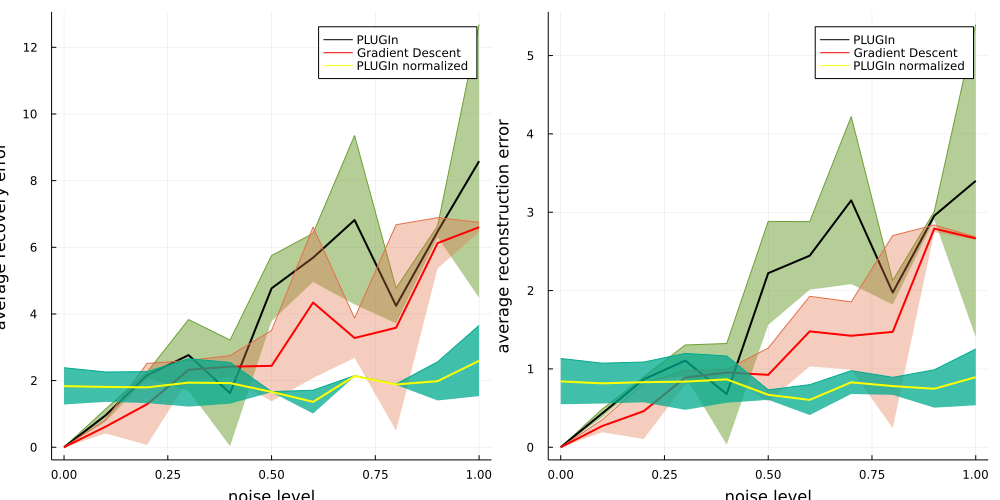

In [64]:
#########  SNR  #################
net_param = [5, 200, 750]
G = create_network(net_param)
W = normalized_weight_product(G)
#######

depth = length(Flux.params(G))/2

(_, z_dim) = size(Flux.params(G)[1]);
(x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
W = normalized_weight_product(G)

max_iter = 1000
stepsize = 1

λ = .2

noise_level_list = 0:.1:1
trials = 2

recov_error_matrix_PLUGIn = zeros(length(noise_level_list))
recon_error_matrix_PLUGIn = zeros(length(noise_level_list))

recov_error_matrix_PLUGIn_reg = zeros(length(noise_level_list))
recon_error_matrix_PLUGIn_reg = zeros(length(noise_level_list))

recov_error_matrix_GD = zeros(length(noise_level_list))
recon_error_matrix_GD = zeros(length(noise_level_list))

z = randn(z_dim)

z_est_PLUGIn = randn(z_dim)
z_est_PLUGIn_reg = randn(z_dim)
z_est_GD = randn(z_dim)

for trial in 1:trials

    recov_error_PLUGIn = []
    recon_error_PLUGIn = []

    recov_error_PLUGIn_reg = []
    recon_error_PLUGIn_reg = []

    recov_error_GD = []
    recon_error_GD = []

    z = randn(z_dim)
    
    for noise_level in noise_level_list
        y = G(z) + noise_level * randn(x_dim)
        descent(z) = gradient(z->norm(G(z) - y,2)^2, z)[1]        

        z_est_PLUGIn = randn(z_dim)
        z_est_PLUGIn_reg = randn(z_dim)
        z_est_GD = randn(z_dim)
        iter = 1
        for iter in 1:max_iter
            z_est_PLUGIn = PLUGIN_denoise(G, W, y, z_est_PLUGIn, stepsize)
            z_est_PLUGIn_reg = PLUGIN_denoise_regularized(G, W, y, z_est_PLUGIn_reg, stepsize, λ)
            d = descent(z_est_GD); z_est_GD -= stepsize *d
        end

        push!(recov_error_PLUGIn, norm(z - z_est_PLUGIn)) #relative_error(z, z_est_PLUGIn))
        push!(recon_error_PLUGIn,  norm(G(z) - G(z_est_PLUGIn))) #relative_error(G(z), G(z_est_PLUGIn)) )

        push!(recov_error_PLUGIn_reg,  norm(z - z_est_PLUGIn_reg)) #relative_error(z, z_est_PLUGIn_reg))
        push!(recon_error_PLUGIn_reg,  norm(G(z) - G(z_est_PLUGIn_reg))) #relative_error(G(z), G(z_est_PLUGIn_reg)) )

        push!(recov_error_GD,  norm(z - z_est_GD)) #relative_error(z, z_est_GD))
        push!(recon_error_GD,  norm(G(z) - G(z_est_GD))) #relative_error(G(z), G(z_est_GD)) )  

    end

    recov_error_matrix_PLUGIn = hcat(recov_error_matrix_PLUGIn, recov_error_PLUGIn)
    recon_error_matrix_PLUGIn =  hcat(recon_error_matrix_PLUGIn, recon_error_PLUGIn)

    recov_error_matrix_PLUGIn_reg = hcat(recov_error_matrix_PLUGIn_reg, recov_error_PLUGIn_reg)
    recon_error_matrix_PLUGIn_reg =  hcat(recon_error_matrix_PLUGIn_reg, recon_error_PLUGIn_reg)

    recov_error_matrix_GD = hcat(recov_error_matrix_GD, recov_error_GD)
    recon_error_matrix_GD = hcat(recon_error_matrix_GD, recon_error_GD)

    println("Done with trial $trial")

end

average_recov = mean(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.5, c = 0, label = false)
plot!(noise_level_list, average_recov, label = "PLUGIn", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:black)

average_recov = mean(recov_error_matrix_GD[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 2, label = false)
plot!(noise_level_list, average_recov, label = "Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:red)


average_recov = mean(recov_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.75, c = 9, label = false)
p1 = plot!(noise_level_list, average_recov, label = "PLUGIn normalized", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:yellow)


average_recon = mean(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.5, c = 0, label = false)
plot!(noise_level_list, average_recon, label = "PLUGIn", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2 , c =:black)


average_recon = mean(recon_error_matrix_GD[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 2, label = false)
plot!(noise_level_list, average_recon, label = "Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)

average_recon = mean(recon_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.75, c = 9, label = false)
p2 = plot!(noise_level_list, average_recon, label = "PLUGIn normalized", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2 , c =:yellow)

######### overfit ##############
# p5, p6 = overfit_plot(G, .5)

gr(size = (1000,500))
# plot(p1,p2,p3,p4,p5,p6, layout = (3,2))
plot(p1,p2, layout = (1,2))

In [60]:
#########  SNR  #################
net_param = [5, 200, 750]
G = create_network(net_param)
W = normalized_weight_product(G)
#######

depth = length(Flux.params(G))/2

(_, z_dim) = size(Flux.params(G)[1]);
(x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
W = normalized_weight_product(G)

max_iter = 1000
stepsize = 1

λ = .1

noise_level_list = 0:.1:1
trials = 2
z = randn(z_dim)
noise_level = 0

y = G(z) + noise_level * randn(x_dim)
descent(z) = gradient(z -> norm(G(z) - y,2)^2, z)[1]        

z_est_PLUGIn = randn(z_dim)
z_est_PLUGIn_reg = randn(z_dim)
z_est_GD = randn(z_dim)
z_est_GD_reg = randn(z_dim)
iter = 1
for iter in 1:max_iter
    z_est_PLUGIn = PLUGIN_denoise(G, W, y, z_est_PLUGIn, stepsize)
    z_est_PLUGIn_reg = PLUGIN_denoise_regularized(G, W, y, z_est_PLUGIn_reg, stepsize, λ)
    d = descent(z_est_GD); z_est_GD -= stepsize *d
end

rel_PLUGIn = relative_error(z, z_est_PLUGIn)
rel_PLUGIn_reg = relative_error(z, z_est_PLUGIn_reg)
rel_GD = relative_error(z, z_est_GD)

println("relative error for PLUGIn: $rel_PLUGIn")
println("relative error for PLUGIn regularized: $rel_PLUGIn_reg")
println("relative error for gradient descent: $rel_GD")


relative error for PLUGIn: 1.0687031027648484e-15
relative error for PLUGIn regularized: 0.6803575779933918
relative error for gradient descent: 1.5602285205608386e-16


In [61]:
norm(z_est_PLUGIn_reg)

0.9843519659367986

In [62]:
norm(z)

3.039859083310871